<a href="https://colab.research.google.com/github/rastringer/promptcraft/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine tuning a model

### Considerations
Why fine-tune?

Prompt design can help guide an LLM to generating relevant responses. Tuning a model can help it learn to respond in a particular style, format, or to provide detailed answers concerning niche material.

### Steps

* Consider the task
* Collect relevant and high-value examples of typical inputs and desired outputs. Try generating data if this step is difficult.
* Begin by tuning a small model (eg > 1B parameters).
* Evaluate whether the LLM has improved.
* Increase amounts of data, task complexity, model size.

### Computational resources

Training a 1B-parameter model will fit on a 16GB GPU, such as an A100. Any model of 5B or more parameters will require 8 x A100s (640GB of memory), or 64 cores of V3 TPUs.

* Please note, since fine tuning is a computationally expensive operation and some users may have to request [additional quota](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-text-models#quota) from GCP.

### PEFT and LoRA

*Parameter-efficient fine tuning* refers to techniques for adapting models that minimize the number of parameters that are updated to improve outputs. PEFT approaches tend to focus on freezing pre-trained weights and updating a minimal set of task-specific parameters. A prevalent example is LoRA.

LoRA (low-rank adaptation) adds *update matrices*, which are pairs of rank-decomposition weight matrices to existing weights. The update matricies are the only weights trained, saving time and memory.

In [ ]:
! pip3 install --upgrade google-cloud-aiplatform
! pip3 install shapely<2.0.0
# We will use the Hugging Face transformers library and datasets
! pip install transformers datasets
!pip install sequence-evaluate
!pip install rouge sentence-transformers

In [3]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

If you're on Colab, authenticate via the following cell

In [1]:
from google.colab import auth
auth.authenticate_user()

Add your project id, project region and a Google Cloud Storage bucket URI.

In [2]:
PROJECT_ID = "<..>"
REGION = "<..>"
BUCKET_URI = "<..>"

In [3]:
import vertexai
vertexai.init(project=PROJECT_ID, location=REGION)

### Data preparation

We will use the Hugging Face datasets library to import [Lamini](https://www.lamini.ai/)'s _open_llms_ dataset, which comprises questions and answers about various large language models.

In [ ]:
import datasets

finetuning_dataset_path = "lamini/open_llms"
finetuning_dataset = datasets.load_dataset(finetuning_dataset_path)
print(finetuning_dataset)

The dataset is downloaded as a data dictionary. Here we convert it into a Pandas dataframe.

In [5]:
import pandas as pd
from datasets import DatasetDict

df = pd.DataFrame(columns=[])

for key in finetuning_dataset:
    dataset_df = pd.DataFrame.from_dict(finetuning_dataset[key])
    df = pd.concat([df, dataset_df])

df.reset_index(drop=True, inplace=True)

For Vertex AI, the question and answer columns have to be named `input_text` and `output_text`.

In [6]:
df = df.rename(columns={
    'question': 'input_text',
    'answer': 'output_text'
})

In [7]:
df.head()

,input_text,output_text,input_ids,attention_mask,labels
0,AlekseyKorshuk-chatml-pyg-v1: AlekseyKorshuk-c...,The None dataset was used for training.,"[44163, 76, 5462, 44, 641, 73, 2788, 14, 23481...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[44163, 76, 5462, 44, 641, 73, 2788, 14, 23481..."
1,EleutherAI-gpt-neox-20b: EleutherAI-gpt-neox-2...,GPT-NeoX-20B's architecture intentionally rese...,"[30377, 16580, 18128, 14, 72, 431, 14, 570, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[30377, 16580, 18128, 14, 72, 431, 14, 570, 10..."
2,EleutherAI-gpt-neox-20b: EleutherAI-gpt-neox-2...,The advantage of using GPT-NeoX-20B is that it...,"[30377, 16580, 18128, 14, 72, 431, 14, 570, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[30377, 16580, 18128, 14, 72, 431, 14, 570, 10..."
3,ausboss-llama-30b-supercot: What parameter siz...,"This LoRA is compatible with any 7B, 13B or 30...","[666, 67, 1730, 14, 620, 2902, 14, 1229, 67, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[666, 67, 1730, 14, 620, 2902, 14, 1229, 67, 1..."
4,CalderaAI-30B-Lazarus: CalderaAI-30B-Lazarus: ...,Answer:,"[4218, 491, 66, 18128, 14, 1229, 35, 14, 45, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[4218, 491, 66, 18128, 14, 1229, 35, 14, 45, 2..."


In [8]:
from sklearn.model_selection import train_test_split

# split is set to 80/20
train, eval = train_test_split(df, test_size=0.2)
print(len(train))

890


See the [docs](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-text-models#prepare_a_dataset) for more details on data requirements.

GCP recommends 100-500 examples to tune a model, so we have ample to get started with almost 900.

In [17]:
eval.head()

,input_text,output_text,input_ids,attention_mask,labels
331,tiiuae-falcon-40b: What is the purpose of larg...,The purpose of large language models is to pro...,"[85, 2886, 86, 3348, 14, 39226, 585, 14, 1449,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[85, 2886, 86, 3348, 14, 39226, 585, 14, 1449,..."
271,stable-vicuna-13b: What datasets are used to t...,"These models are trained on various datasets, ...","[11351, 14, 19742, 9821, 14, 1012, 67, 27, 173...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[11351, 14, 19742, 9821, 14, 1012, 67, 27, 173..."
468,EleutherAI-gpt-j-6b: EleutherAI-gpt-j-6b: Eleu...,To maximize the likelihood of predicting the n...,"[30377, 16580, 18128, 14, 72, 431, 14, 75, 14,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[30377, 16580, 18128, 14, 72, 431, 14, 75, 14,..."
488,llama-30b: llama-30b: Who is eligible to acces...,Access to the model is granted on a case-by-ca...,"[620, 2902, 14, 1229, 67, 27, 26198, 2902, 14,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[620, 2902, 14, 1229, 67, 27, 26198, 2902, 14,..."
723,CalderaAI-30B-Lazarus: CalderaAI-30B-Lazarus: ...,The desired outcome of using LoRAs on language...,"[4218, 491, 66, 18128, 14, 1229, 35, 14, 45, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[4218, 491, 66, 18128, 14, 1229, 35, 14, 45, 2..."


We now convert the training data to the required JSON Lines format, in which each line contains a single training example. We store the file in the GCS bucket.

In [29]:
tune_jsonl = train.to_json(orient="records", lines=True)

print(f"Length: {len(tune_jsonl)}")
print(tune_jsonl[0:100])

Length: 668339
{"input_text":"llama-65b: When was LLaMA released?","output_text":"LLaMA was released on February 24


In [30]:
training_data_filename = "tune_open_llms.jsonl"

with open(training_data_filename, "w") as f:
    f.write(tune_jsonl)

In [ ]:
! gsutil cp $training_data_filename $BUCKET_URI

In [32]:
TRAINING_DATA_URI = f"{BUCKET_URI}/{training_data_filename}"

In [33]:
MODEL_NAME = f"fine-tuned-open-llms"

In [39]:
from vertexai.preview.language_models import TextGenerationModel

# Tuning job
def tuned_model(
    project_id: str,
    location: str,
    training_data: str, # the GCS URI of the JSONL file
    model_display_name: str, # name of the model
    train_steps=100, # number of training steps when tuning the model
):
    # References our base model, bison
    model = TextGenerationModel.from_pretrained("text-bison@001")
    model.tune_model(
        training_data=training_data,
        model_display_name=model_display_name,
        train_steps=train_steps,
        # Tuning can only happen in the "europe-west4" location
        tuning_job_location="europe-west4",
        # Model can only be deployed in the "us-central1" location
        tuned_model_location="us-central1",
    )

    # Test the tuned model:
    print(
        model.predict(
            "ausboss-llama-30b-supercot: What parameter sizes is this LoRA compatible with?"
        )
    )

    return model

In [ ]:
model = tuned_model(PROJECT_ID, REGION, TRAINING_DATA_URI, MODEL_NAME)

### View a list of tuned models

If you have already tuned or imported a model, or your Colab session had to be reconnected, you can use this function to load it.

In [84]:
from vertexai.preview.language_models import TextGenerationModel

def list_tuned_models(
    project_id: str,
    location: str,
) -> None:
    """List tuned models."""
    vertexai.init(project=project_id, location=location)
    model = TextGenerationModel.from_pretrained("text-bison@001")
    tuned_model_names = model.list_tuned_model_names()
    print(tuned_model_names)

In [ ]:
list_tuned_models(project_id=PROJECT_ID, location=REGION)

### Load the tuned model

In [86]:
parameters = {
    "max_output_tokens": 1024,
    "temperature": 0.1,
    "top_p": 0.8,
    "top_k": 40
}

original_model = TextGenerationModel.from_pretrained("text-bison@001")
# Add the ouptut from list_tuned_models above
tuned_model = original_model.get_tuned_model("<..>")
response = tuned_model.predict(
    """"EleutherAI-gpt-neox-20b: What techniques were used to distribute the model across GPUs?"?""",
    **parameters
    )
print(f"Response from tuned model: {response.text}")


Response from tuned model: The techniques used to distribute the model across GPUs were:

1. TPUs were used to distribute the model across GPUs.
2. The model was distributed across GPUs using TPUs.
3. The model was distributed across GPUs using TPUs.


In [64]:
def gen_eval_answers(model_, eval_data):
  eval_data = eval_data[:5]  # you can change the number of rows you want to use
  eval_q = eval_data["input_text"]
  eval_answer = eval_data["output_text"]
  # answers is a list of the model outputs
  answers = []

  for i in eval_q:
      response = model_.predict(i)
      answers.append(response.text)
  # ground_truths is the original output_text from the dataset
  ground_truths = eval_answer.tolist()
  return answers, ground_truths

Occasionally a response by the model will trigger safety flags that lead to an empty output, so we need a function to ensure that any empty entries (" ") in `answers` are deleted, along with their counterpart entry in `ground_truths`.

In [65]:
def filter_empty(ans, truths):

  filtered_answers = []
  filtered_ground_truths = []

  for i, (ans, gt) in enumerate(zip(ans, truths)):
    if ans != "":
      filtered_answers.append(ans)
      filtered_ground_truths.append(gt)

  if len(filtered_answers) != len(filtered_ground_truths):
    raise ValueError("Filtered lists have unequal length")

  return filtered_answers, filtered_ground_truths

### Evaluation

Evaluating language models is complicated, and a quickly-evolving field.

In this notebook, we will use [sequence-evaluate](https://pypi.org/project/sequence-evaluate/), which allows us to check the following scores:

* BLEU: a measure of similarity between the model outputs and human-written benchmark text (our `ground_truths`).

* ROUGE: measures the overlap between model outputs and `ground_truths`.

In [71]:
from seq_eval import SeqEval

def evaluate(model_, eval_data):
  answers, ground_truths = gen_eval_answers(model_, eval)
  filtered_answers, filtered_ground_truths = filter_empty(answers, ground_truths)
  evaluator = SeqEval()
  scores = evaluator.evaluate(filtered_answers, filtered_ground_truths, verbose=False)
  return scores

In [72]:
original_model_scores = evaluate(original_model, eval)

In [74]:
tuned_model_scores = evaluate(tuned_model, eval)
print(tuned_model_scores)

{'bleu_1': 0.24233021044554298, 'bleu_2': 0.20119113021360832, 'bleu_3': 0.18451727800543202, 'bleu_4': 0.1687980254687695, 'rouge_1_precision': 0.46880952380952384, 'rouge_1_recall': 0.3044662309368192, 'rouge_1_f1': 0.3548340656552031, 'rouge_2_precision': 0.2986842105263158, 'rouge_2_recall': 0.19130564263322883, 'rouge_2_f1': 0.23037575647430647, 'rouge_l_precision': 0.46880952380952384, 'rouge_l_recall': 0.3044662309368192, 'rouge_l_f1': 0.3548340656552031, 'inter_dist1': 0.0670611426615179, 'inter_dist2': 0.33266931608228656, 'intra_dist1': 0.2564452052802795, 'intra_dist2': 0.6822323896137757, 'semantic_textual_similarity': 0.6141194343566895}


### Results

Now we can create a dataframe and visualize if our tuning has yielded any benefits over the original model.

In [77]:
# Create a DataFrame from each dictionary
df1 = pd.DataFrame([original_model_scores], index=['original_model'])
df2 = pd.DataFrame([tuned_model_scores], index=['tuned_model'])

# Concatenate the DataFrames vertically
result_df = pd.concat([df1, df2])

result_df.head()

,bleu_1,bleu_2,bleu_3,bleu_4,rouge_1_precision,rouge_1_recall,rouge_1_f1,rouge_2_precision,rouge_2_recall,rouge_2_f1,rouge_l_precision,rouge_l_recall,rouge_l_f1,inter_dist1,inter_dist2,intra_dist1,intra_dist2,semantic_textual_similarity
original_model,0.104945,0.071229,0.059507,0.048115,0.203196,0.330501,0.219252,0.083341,0.150202,0.092441,0.183713,0.314760,0.204785,0.025554,0.172547,0.117250,0.444751,0.583566
tuned_model,0.242330,0.201191,0.184517,0.168798,0.468810,0.304466,0.354834,0.298684,0.191306,0.230376,0.468810,0.304466,0.354834,0.067061,0.332669,0.256445,0.682232,0.614119


A visualization will make our evaluation easier. Higher scores are of course better in this case.

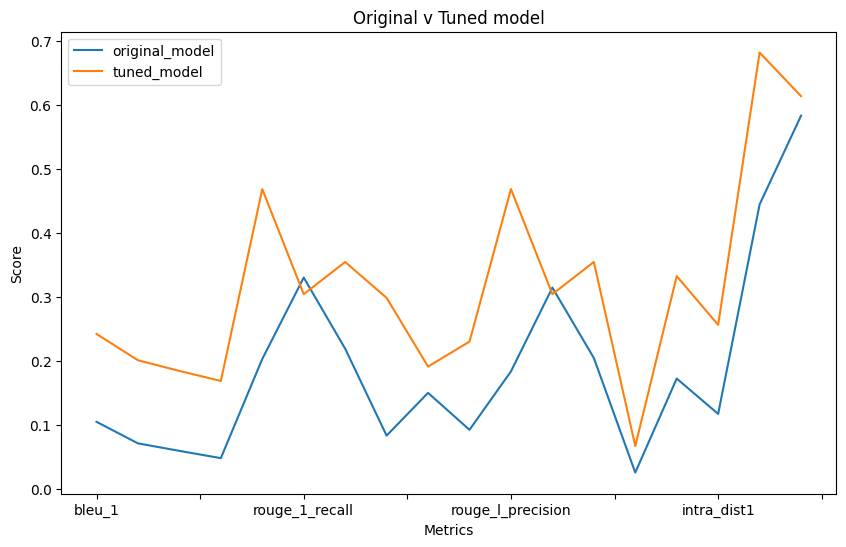

In [82]:
import matplotlib.pyplot as plt

result_df.transpose().plot(kind='line', figsize=(10, 6))
plt.title('Original v Tuned model')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(['original_model', 'tuned_model'])
plt.show()